In [171]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from shapely import Point, LineString, Polygon
import shapely
import random
from enum import Enum
from rasterio.mask import mask
from CPP_Planner import CPP_Planner_Kit

In [172]:
# hard-code 各个列表
swath_sep_indxes = [0, 28, 39, 49, 71]
useful_land_indexes = [0, 4, 5, 6]
# 一些农机数据
vehicle_weight = 1980 + 342.5  # 拖拉机 + 耕作机械 重量（kg）
vehicle_wheel_width = 1440  # 农机轮距（mm）

opti_path = '../PSO_opt_result/opt18/pso_result.csv'
# real_swath_path = '../Scratch/test_Load_Shp/test_shps/swath_group_1.shp'
# straight_swath_path = 'GIS_data/straight_swaths/straight_swaths.shp'
real_swath_path = r'GIS_data/路径规划优化用数据/all_swaths/all_swaths_group.shp'
straight_swath_path = r'GIS_data/路径规划优化用数据/all_swaths/all_straight_swaths_group.shp'
opti_parameters = pd.read_csv(opti_path)
real_swath = gpd.read_file(real_swath_path)
straight_swath = gpd.read_file(straight_swath_path)
all_land = gpd.read_file('../Scratch/test_Load_Shp/shp_file/村地和道路/村地地块区域.shp')
print(opti_parameters.shape)
print('straight and real swaths: ', len(straight_swath), end=' ')
print(len(real_swath))

raw_data = pd.read_csv('exhalf_1m_preci_sample_DASC_sep_land_0.csv')
data_array = raw_data.to_numpy()

straight_swaths = []
for temp_line in real_swath.geometry:
    temp_simplified_line = temp_line.simplify(0.8, preserve_topology=False)
    straight_swaths.append(temp_simplified_line)
# straight_swath = gpd.GeoDataFrame(geometry=straight_swaths, crs=real_swath.crs)

(20, 4)
straight and real swaths:  71 71


In [173]:
with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/dem_halfM_clip1.tif') as dem_src:
    dem_array = dem_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/Aspect_halfM_clip1.tif') as aspect_src:
    aspect_array = aspect_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/Slope_clip_halfM1.tif') as slope_src:
    slope_array = slope_src.read(1)
with rasterio.open('GIS_data/路径规划优化用数据/halfM_tifs/Curvatu_halfM_clip1.tif') as curvature_src:
    curvature_array = curvature_src.read(1)
[dem_array.shape, aspect_array.shape, slope_array.shape, curvature_array.shape]

[(2025, 1767), (2025, 1767), (2025, 1767), (2025, 1767)]

In [174]:
# 取出当前位置上的地形信息
class raster(Enum):
    DEM = 1
    ASPECT = 2
    SLOPE = 3
    CURVATURE = 4
def get_11_from_raster(point: Point, category):    
    if category == raster.SLOPE:
        temp_raster = slope_array
        temp_src = slope_src
    elif category == raster.ASPECT:
        temp_raster = aspect_array
        temp_src = aspect_src
    elif category == raster.CURVATURE:
        temp_raster = curvature_array
        temp_src = curvature_src
    else:
        temp_raster = dem_array
        temp_src = dem_src
    row, col = temp_src.index(point.x, point.y)
    return temp_raster[row, col]

In [175]:
def model_fit_3(lambdas, data):
    aspect = np.deg2rad(data[3])
    origin_x, origin_y, height, slope = data[0], data[1], data[2], data[4]
    slope = np.deg2rad(slope)
    aspect = np.deg2rad(aspect)
    # slope_rad = np.deg2rad(slope)
    x_off = lambdas[0] * np.cos(aspect) * vehicle_weight * slope
    y_off = lambdas[1] * np.sin(aspect) * vehicle_weight * slope

    new_x = origin_x + x_off
    new_y = origin_y + y_off
    return Point(new_x, new_y)

In [176]:
precision = 200000
count = 1000
offset = 100
SAMPLE_BATCH = 200
jump = 5
min_param = []
min_dis = 9999
for i in range(-count, count, jump):
    temp_sample = np.random.choice(data_array.shape[0], SAMPLE_BATCH, replace=False)
    temp_sample = data_array[temp_sample]
    param_x = i / precision
    for j in range(-count, count, jump):
        param_y = j / precision
        
        origin_x = temp_sample[:, 0]
        origin_y = temp_sample[:, 1]
        aspect = temp_sample[:, 3]
        slope = temp_sample[:, 4]
        labels = temp_sample[:, 6].astype(np.int32)
        # 计算off
        new_x = origin_x + param_x * np.cos(np.deg2rad(aspect)) * slope
        new_y = origin_y + param_y * np.sin(np.deg2rad(aspect)) * slope
        
        distances = []
        for temp_x, temp_y, label in zip(new_x, new_y, labels):
            distances.append(Point(temp_x, temp_y).distance(real_swath.geometry.iloc[label]))
        if min_dis > np.mean(distances):
            min_dis = np.mean(distances)
            min_param = [param_x, param_y]
min_param
# temp good: [-0.000355, 0.00021]


[0.002075, -0.005]

simulation begin


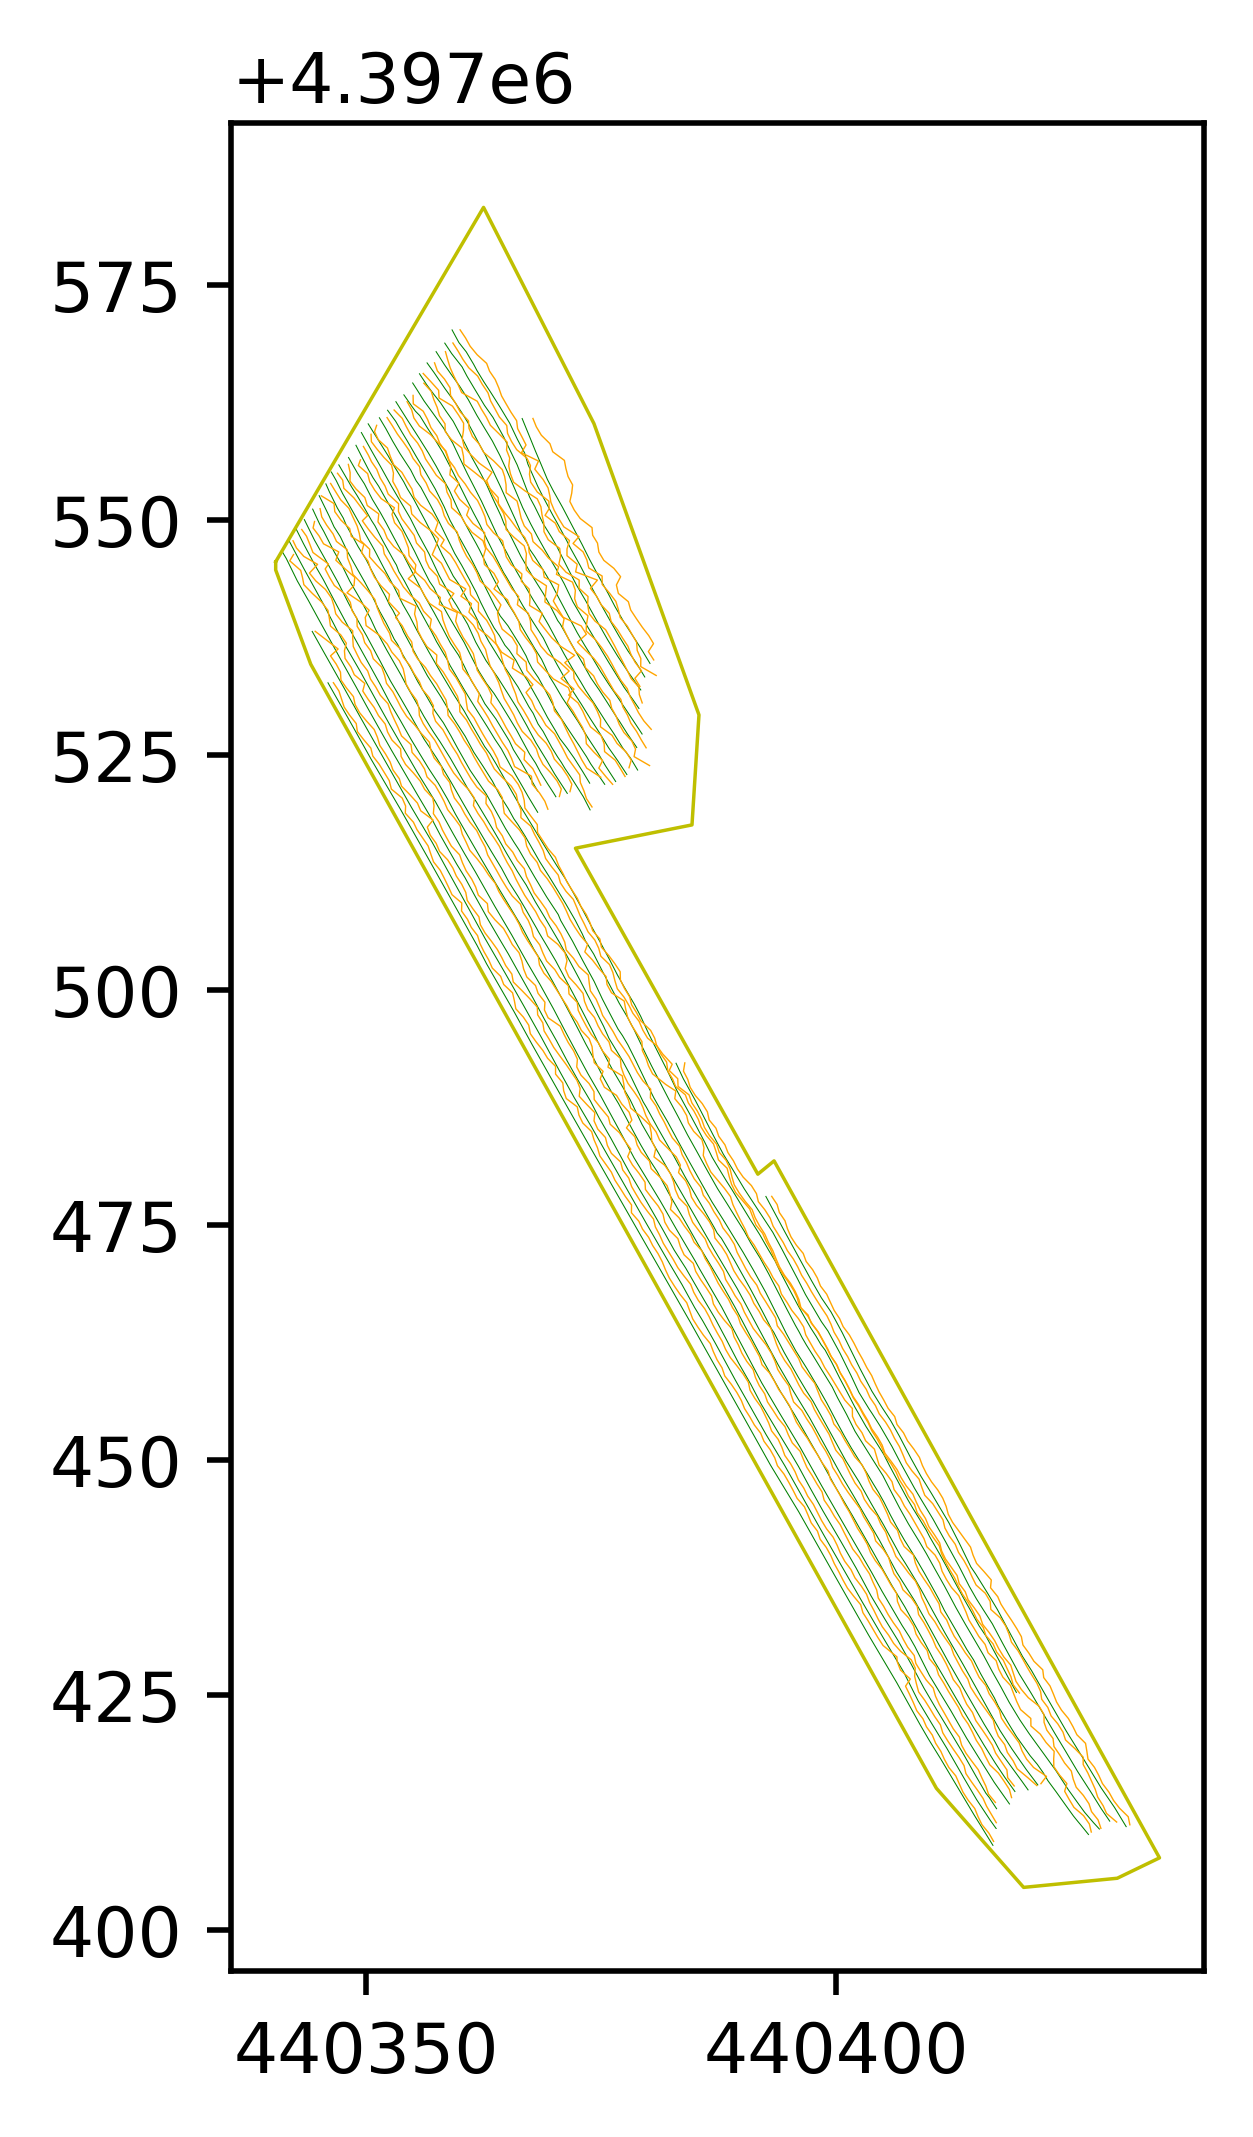

In [177]:
optimal_params = min_param
real_swath = real_swath[: 28]
land_ind = 0
# 显示结果
algor_gen_shp_path = r'../gen_paths/gen_02/gen_01.shp'
algor_gen_shp = gpd.read_file(algor_gen_shp_path)
# straight_swath = algor_gen_shp
# 查看所有的路径
_, ax = plt.subplots(dpi=500)
ax.set_aspect('equal')
sample_accuracy = 1
# straight_swath.plot(ax=ax, color='black', linewidth=0.15)
real_swath.plot(ax=ax, color='g', linewidth=0.15)
ax.plot(*all_land.geometry.iloc[useful_land_indexes[land_ind]].exterior.xy, color='y', linewidth=0.5)

all_distance_data = []
all_simulated_lines = []

print('simulation begin')
for temp_real_line, temp_straight_line in zip(real_swath.geometry, straight_swath.geometry):
    # samples = np.arange(0, temp_real_line.length, sample_accuracy)
    samples = np.arange(0, temp_straight_line.length, sample_accuracy)
    temp_result_points = []
    temp_distance_data = []
    for i, sample in enumerate(samples):
        # TODO: 找到问题所在
        temp_sample_point = temp_straight_line.interpolate(sample)
        temp_point_data = [
            temp_sample_point.x, temp_sample_point.y,
            get_11_from_raster(temp_sample_point, raster.DEM),
            get_11_from_raster(temp_sample_point, raster.ASPECT),
            get_11_from_raster(temp_sample_point, raster.SLOPE),
            # abs(get_11_from_raster(temp_sample_point, raster.SLOPE) - single_slope_mean),
            get_11_from_raster(temp_sample_point, raster.CURVATURE)
        ]
        # temp_simu_point = model_fit(optimal_params[1:], temp_point_data)
        # temp_simu_point = model_fit_2(optimal_params[1:], temp_point_data)
        temp_simu_point = model_fit_3(optimal_params, temp_point_data)
        temp_result_points.append(temp_simu_point)
        # 计算距离
        temp_distance_data.append(temp_simu_point.distance(temp_real_line))
    all_distance_data.append(temp_distance_data)
    # print(len(temp_result_points))
    temp_modi_line = LineString(temp_result_points)
    all_simulated_lines.append(temp_modi_line)
    ax.plot(*temp_modi_line.xy, color='orange', linewidth=0.2)
# straight_swath.plot(ax=ax, color='black', linewidth=0.15, linestyle='--')
# plt.legend(['real swath', 'straight swath', 'land boundary', 'simulation'])
# plt.legend(['real swath', 'land boundary', 'simulation'], fontsize=5)
# print('saving')
# plt.savefig('swath_simu.png', dpi=1000)
all_simulated_lines = gpd.GeoDataFrame(geometry=all_simulated_lines)

straight len 2428


/Users/outianyi/miniforge3/envs/ML/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/outianyi/miniforge3/envs/ML/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

<Figure size 1600x400 with 0 Axes>

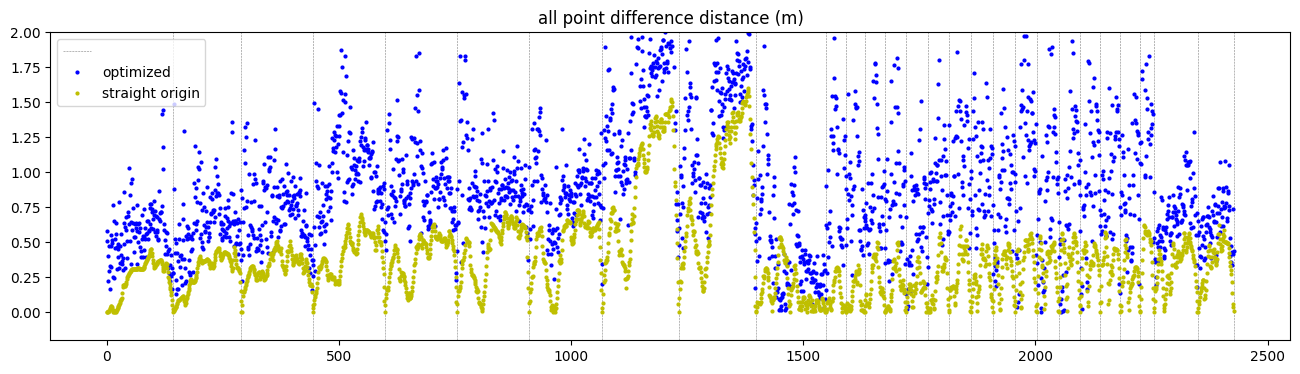

In [178]:
all_distance_combine = []
flatten_distances = []
flatten_gap = []
# 控制 plt 的长宽比为 4: 1
plt.figure(figsize=(16, 4))
for i in all_distance_data:
    flatten_distances += i
    flatten_gap.append(len(i))
flatten_distances = np.array(flatten_distances)
    
straight_distance_data = []
for temp_real_line, temp_straight_line in zip(real_swath.geometry, straight_swath.geometry):
    # samples = np.arange(0, temp_real_line.length, sample_accuracy)
    samples = np.arange(0, temp_straight_line.length, sample_accuracy)
    temp_distance_data = []
    for i, sample in enumerate(samples):
        temp_sample_point = temp_straight_line.interpolate(sample)
        temp_distance_data.append(temp_sample_point.distance(temp_real_line))
    # straight_distance_data.append(temp_distance_data)
    straight_distance_data += temp_distance_data
all_distance_data_combine = []

print('straight len', len(straight_distance_data))

plt.figure(figsize=(16, 4))
plt.vlines(np.cumsum(flatten_gap), ymin=-0.2, ymax=2.5, colors="gray", linestyles="dashed", linewidth=0.4)
plt.ylim((-0.2, 2))
plt.plot(flatten_distances, c='b', marker='o', markersize=2, linestyle=' ')
plt.plot(straight_distance_data, c='y', marker='o', markersize=2, linestyle=' ')
# 在固定的 x 位置上显示竖直的虚线
plt.title("all point difference distance (m)")
plt.legend(['', 'optimized', 'straight origin'])
np.mean(all_distance_combine)

nan

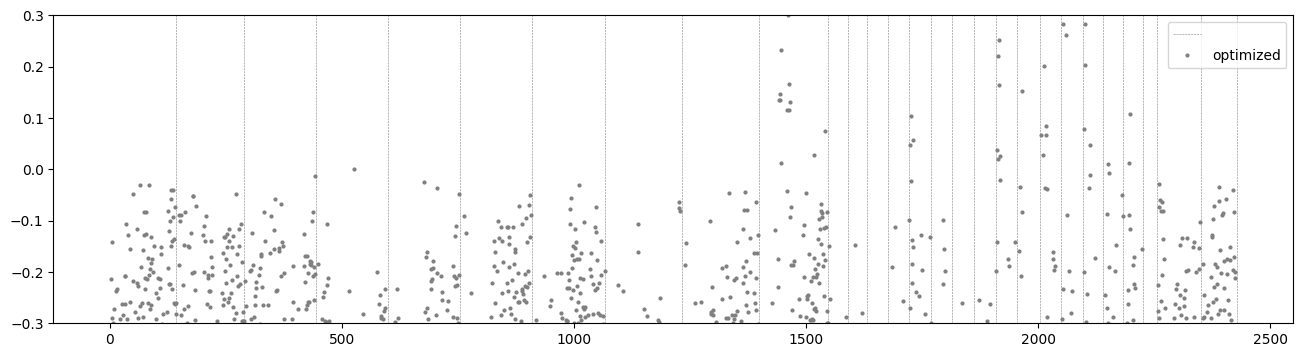

In [179]:
difference = straight_distance_data - flatten_distances
lim = [-0.3, 0.3]
plt.figure(figsize=(16, 4))
plt.vlines(np.cumsum(flatten_gap), ymin=lim[0], ymax=lim[1], colors="gray", linestyles="dashed", linewidth=0.4)
plt.ylim(lim)
# plt.plot(flatten_distances, c='b', marker='o', markersize=2, linestyle=' ')
# plt.plot(straight_distance_data, c='y', marker='o', markersize=2, linestyle=' ')
plt.plot(difference, c='gray', marker='o', markersize=2, linestyle=' ')
# 在固定的 x 位置上显示竖直的虚线
plt.legend(['', 'optimized', 'straight origin'])
np.mean(all_distance_combine)